# February DS/AL-ML + BIA Data Jam - US Consumer Behavior

## I. Problem Statement: 

### Has inflation permanently changed consumer behavior in the U.S?

## Introduction

The project is to collaboratively evaluate the claim using real U.S. macroeconomic data from Federal Reserve Economic Data (FRED) and present a clear, evidence-based conclusion. We will explore how inflation has structurally altered consumer spending, saving, and borrowing habits.

## 1. Environment Setup & Data Loading

In [1]:
# Import necessary libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries for machine learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the starter datasets
credit_owned = pd.read_csv('../data/CREDIT_OWNED.csv')
personal_expenditure = pd.read_csv('../data/PERSONAL_EXPENDITURE.csv')
saving_rate = pd.read_csv('../data/SAVING_RATE.csv')
cpi = pd.read_csv('../data/cpiaucsl.csv')

## 2. Initial Data Inspection
Before merging, we must understand the shape, completeness, and historical timelines of our individual datasets.

In [3]:
# Display the first few rows of each dataset
datasets = {
    'Credit Owned': credit_owned,
    'Personal Expenditure': personal_expenditure,
    'Saving Rate': saving_rate,
    'CPI': cpi
}

for name, df in datasets.items():
    print(f"{name} Dataset:")
    display(df.head())
    print("\n")

Credit Owned Dataset:


,observation_date,TOTALSL
0,1943-01-01,6577.83
1,1943-02-01,6463.04
2,1943-03-01,6234.21
3,1943-04-01,6125.75
4,1943-05-01,5936.26




Personal Expenditure Dataset:


,observation_date,PCEC96
0,2007-01-01,11181.0
1,2007-02-01,11178.2
2,2007-03-01,11190.7
3,2007-04-01,11201.5
4,2007-05-01,11218.0




Saving Rate Dataset:


,observation_date,PSAVERT
0,1959-01-01,11.3
1,1959-02-01,10.6
2,1959-03-01,10.3
3,1959-04-01,11.2
4,1959-05-01,10.6




CPI Dataset:


,observation_date,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [4]:
# Determining the size of all the DataFrames

for name, df in datasets.items():
    print(f"{name} Dataset Shape: {df.shape}")

Credit Owned Dataset Shape: (995, 2)
Personal Expenditure Dataset Shape: (227, 2)
Saving Rate Dataset Shape: (803, 2)
CPI Dataset Shape: (949, 2)


In [5]:
# Display informative summary of each dataset
for name, df in datasets.items():
    print(f"{name} Informative Summary:")
    df.info()
    print("\n")

Credit Owned Informative Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  995 non-null    object 
 1   TOTALSL           995 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.7+ KB


Personal Expenditure Informative Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  227 non-null    object 
 1   PCEC96            227 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.7+ KB


Saving Rate Informative Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  


In [6]:
# Display descriptive statistics of each dataset
for name, df in datasets.items():
    print(f"{name} Descriptive Statistics:")
    display(df.describe()) 

Credit Owned Descriptive Statistics:


,TOTALSL
count,9.950000e+02
mean,1.230814e+06
std,1.481781e+06
min,5.354360e+03
25%,7.464136e+04
50%,4.809945e+05
75%,2.215879e+06
max,5.084831e+06


Personal Expenditure Descriptive Statistics:


,PCEC96
count,227.000000
mean,13176.984581
std,1724.263802
min,11068.000000
25%,11555.000000
50%,12884.000000
75%,14455.350000
max,16715.400000


Saving Rate Descriptive Statistics:


,PSAVERT
count,803.000000
mean,8.404857
std,3.424809
min,1.400000
25%,5.700000
50%,8.300000
75%,11.100000
max,31.800000


CPI Descriptive Statistics:


,CPIAUCSL
count,948.000000
mean,124.062082
std,89.409534
min,21.480000
25%,32.825000
50%,109.650000
75%,199.950000
max,326.588000


In [7]:
# Check for missing values and duplicates
for name, df in zip(['Credit', 'Expenditure', 'Saving', 'CPI'], [credit_owned, personal_expenditure, saving_rate, cpi]):
    print(f"{name} - Missing: {df.isnull().sum().sum()} | Duplicates: {df.duplicated().sum()}")

Credit - Missing: 0 | Duplicates: 0
Expenditure - Missing: 0 | Duplicates: 0
Saving - Missing: 0 | Duplicates: 0
CPI - Missing: 1 | Duplicates: 0


## 3. Clean & Merge Data
**Observation:** Our inspection reveals a significant misalignment in our historical data:
* `credit_owned` contains 995 rows (starting in 1943).
* `saving_rate` contains 803 rows (starting in 1959).
* `personal_expenditure` contains 227 rows (starting in 2007).

**Action:** Because machine learning models require uniform metrices without missing values across features, we cannot simply concatenate these files. We must standardize the date columns to a `datetime` object and perform an **inner join**. This will naturally trim our timeline to start around 2007 (the earliest shared date across all datasets), ensuring we are only analyzing periods where we have a complete macroeconomic picture.

In [8]:
# Standardize the date column names and cast to datetime objects
for df in [credit_owned, saving_rate, personal_expenditure, cpi]:
    # Rename the first column to 'DATE' regardless of what FRED named it
    df.rename(columns={df.columns[0]: 'DATE'}, inplace=True)
    df['DATE'] = pd.to_datetime(df['DATE'])

# Perform the Inner Merge on the unified DATE key
master_df = personal_expenditure.merge(saving_rate, on='DATE', how='inner') \
                                .merge(credit_owned, on='DATE', how='inner') \
                                .merge(cpi, on='DATE', how='inner')

# Rename columns to be more descriptive
master_df.rename(columns={
    'PCEC96': 'expenditure_billions',
    'PSAVERT': 'saving_rate_pct',
    'TOTALSL': 'credit_owned_billions',
    'CPIAUCSL': 'cpi_index',
    'DATE': 'date'
}, inplace=True)

# Ensure chronological order
master_df.sort_values('date', inplace=True)

## 4. Feature Engineering
Raw nominal dollars and static percentages are difficult for ML algorithms to interpret over long periods. We will engineer new features that capture *behavioral momentum* and *macroeconomic stress*.

In [9]:
# 1. Ratio Features
master_df['credit_to_spend_ratio'] = master_df['credit_owned_billions'] / master_df['expenditure_billions']

# 2. Year-over-Year (YoY) Growth Features
master_df['spend_yoy_growth'] = master_df['expenditure_billions'].pct_change(periods=12) * 100
master_df['credit_yoy_growth'] = master_df['credit_owned_billions'].pct_change(periods=12) * 100
master_df['inflation_yoy'] = master_df['cpi_index'].pct_change(periods=12) * 100

# 3. Regime Categorization
def assign_regime(date):
    if date < pd.to_datetime('2020-03-01'):
        return '1_pre_covid'
    elif date < pd.to_datetime('2021-06-01'):
        return '2_covid_stimulus'
    else:
        return '3_post_inflation_shock'

master_df['regime'] = master_df['date'].apply(assign_regime)

# Drop the first 12 months which now contain NaNs due to the YoY calculation
master_df.dropna(inplace=True)

### Engineered Features Explained
To successfully model consumer behavior, we derived the following indicators:

* **`credit_to_spend_ratio`:** A proxy for financial health. It measures how much outstanding debt consumers hold relative to their current spending levels. An increasing ratio suggests consumers are relying heavier on credit to fund their lifestyle.
* **`spend_yoy_growth` & `credit_yoy_growth`:** Year-over-year percentage changes. Using a 12-month lookback completely removes annual seasonality (e.g., the December holiday shopping spike) and allows our models to measure true behavioral momentum.
* **`inflation_yoy`:** The core driver of our hypothesis. This translates the raw CPI index into the actual inflation rate experienced by consumers over the last 12 months. 
* **`regime`:** A categorical flag that splits the timeline into three distinct economic eras (`1_pre_covid`, `2_covid_stimulus`, and `3_post_inflation_shock`). This is critical for detecting structural breaks, as it allows our models to compare pre-shock behavior against post-shock behavior.

In [10]:
# Save the enriched dataset
master_df.to_csv('../data/master_df.csv', index=False)
print(f"Data successfully cleaned and saved! Final shape: {master_df.shape}")
display(master_df.head())

Data successfully cleaned and saved! Final shape: (214, 10)


,date,expenditure_billions,saving_rate_pct,credit_owned_billions,cpi_index,credit_to_spend_ratio,spend_yoy_growth,credit_yoy_growth,inflation_yoy,regime
12,2008-01-01,11333.2,2.6,2619427.65,212.174,231.128688,1.361238,6.569798,4.294696,1_pre_covid
13,2008-02-01,11293.9,3.0,2634496.42,212.687,233.267199,1.035050,6.657618,4.142959,1_pre_covid
14,2008-03-01,11322.1,2.9,2645603.64,213.448,233.667221,1.174189,6.487213,3.974904,1_pre_covid
15,2008-04-01,11340.5,2.4,2654243.23,213.942,234.049930,1.240905,6.436682,3.903761,1_pre_covid
16,2008-05-01,11361.6,6.8,2660193.15,215.208,234.138955,1.280086,5.983113,4.088414,1_pre_covid


In [11]:
# Display the informative summary and descriptive statistics of the master dataset
print("Master Dataset Informative Summary:")
master_df.info()

print("\nMaster Dataset Descriptive Statistics:")
display(master_df.describe())

Master Dataset Informative Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 12 to 226
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   214 non-null    datetime64[ns]
 1   expenditure_billions   214 non-null    float64       
 2   saving_rate_pct        214 non-null    float64       
 3   credit_owned_billions  214 non-null    float64       
 4   cpi_index              214 non-null    float64       
 5   credit_to_spend_ratio  214 non-null    float64       
 6   spend_yoy_growth       214 non-null    float64       
 7   credit_yoy_growth      214 non-null    float64       
 8   inflation_yoy          214 non-null    float64       
 9   regime                 214 non-null    object        
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 18.4+ KB

Master Dataset Descriptive Statistics:


,date,expenditure_billions,saving_rate_pct,credit_owned_billions,cpi_index,credit_to_spend_ratio,spend_yoy_growth,credit_yoy_growth,inflation_yoy
count,214,214.000000,214.000000,2.140000e+02,214.000000,214.000000,214.000000,214.000000,214.000000
mean,2016-11-15 10:25:47.663551488,13268.524766,6.504206,3.679285e+06,252.884322,273.774763,2.198572,3.977635,2.495761
min,2008-01-01 00:00:00,11068.000000,2.200000,2.518416e+06,211.398000,220.913969,-14.663060,-4.112455,-1.958761
25%,2012-06-08 12:00:00,11677.950000,5.200000,2.832401e+06,228.902000,242.790397,1.341751,2.060922,1.377980
50%,2016-11-16 00:00:00,13017.900000,5.800000,3.627336e+06,242.331500,277.264068,2.360903,4.844202,2.138630
75%,2021-04-23 12:00:00,14789.850000,6.675000,4.231145e+06,267.940750,296.945521,2.967038,6.467816,3.085566
max,2025-11-01 00:00:00,16715.400000,31.800000,5.084831e+06,325.063000,348.083924,25.404709,10.110620,8.979361
std,NaN,1697.182543,3.426797,8.519938e+05,32.659791,30.405591,3.041174,3.275900,2.007583


In [12]:
# Rechecking for missing values and duplicates in the master dataset
print(f"Master Dataset - Missing: {master_df.isnull().sum().sum()} | Duplicates: {master_df.duplicated().sum()}")


Master Dataset - Missing: 0 | Duplicates: 0


## Data Analysis

1.1 Time Series Graphs

In [13]:
# Define regime shading boundaries
regime_bounds = [
    ('1_pre_covid', 'Pre-COVID', 'green'),
    ('2_covid_stimulus', 'COVID Stimulus', 'orange'),
    ('3_post_inflation_shock', 'Post-Inflation Shock', 'red')
]

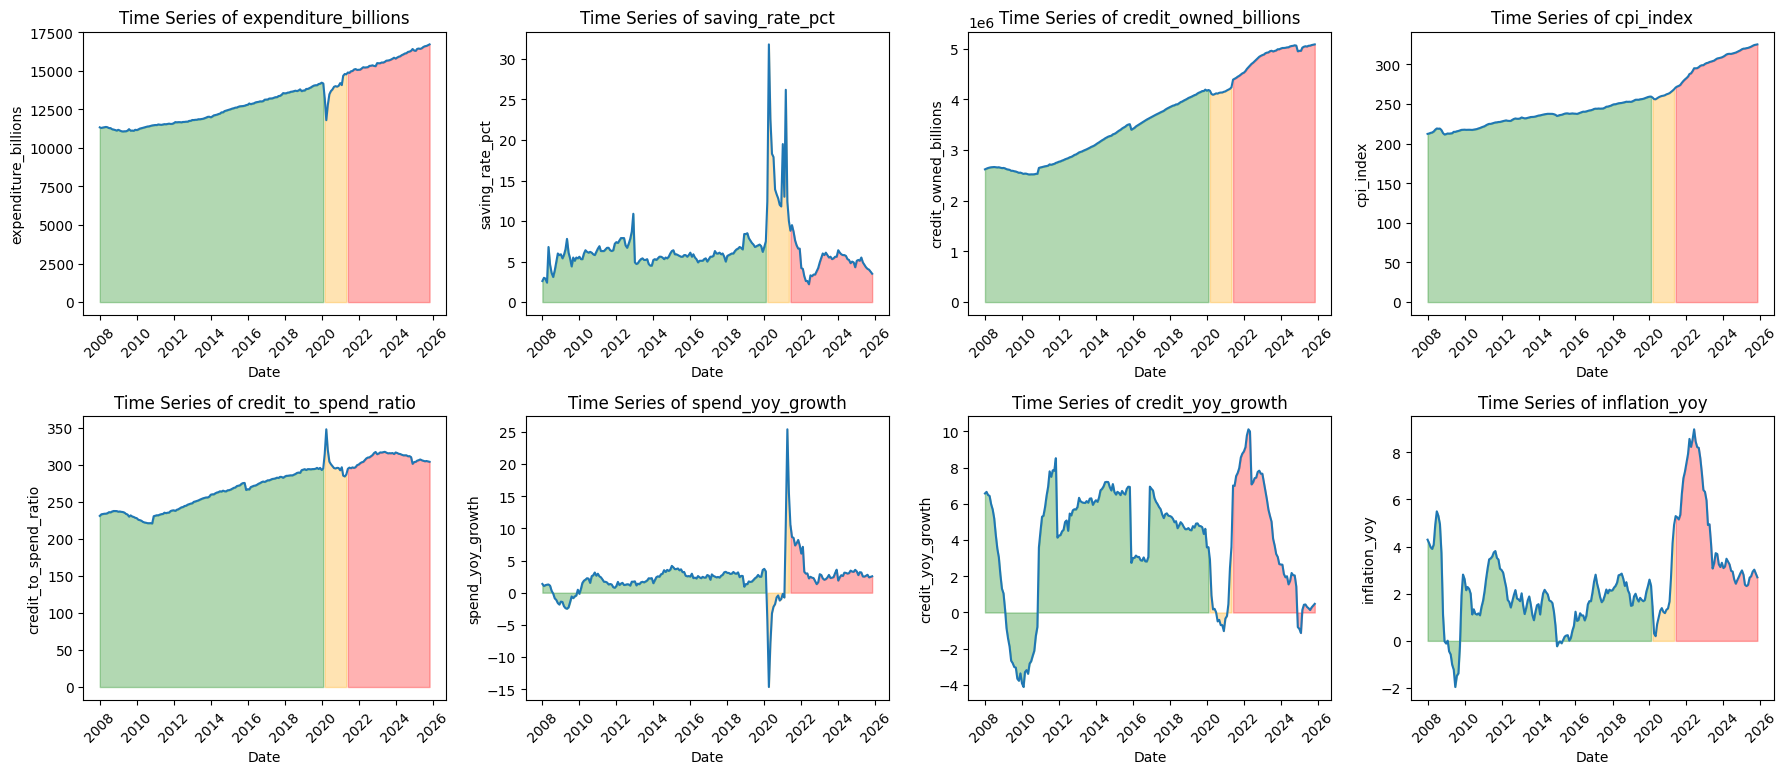

In [14]:
# Visualize the time series of all numeric features in the master dataset
numeric_cols = master_df.select_dtypes(include=[np.number]).columns

n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].set_title(f'Time Series of {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    sns.lineplot(data=master_df, x='date', y=col, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)

    for regime, label, color in regime_bounds:
        regime_data = master_df[master_df['regime'] == regime]
        axes[i].fill_between(regime_data['date'], regime_data[col], alpha=0.3, color=color, label=label)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

1.2 Heatmap Correlation

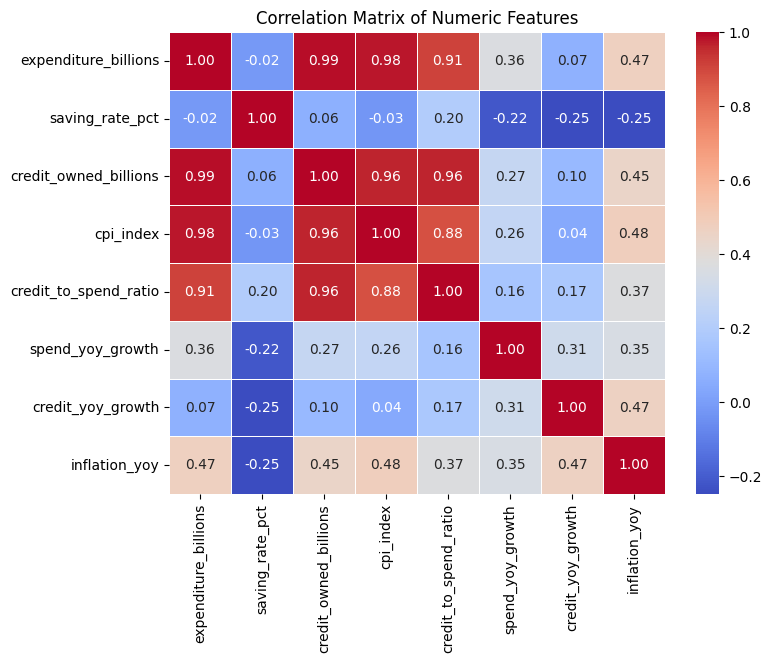

In [15]:
corr_matrix = master_df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

## Model Training

DS / AI-ML students focus on modelling, forecasting, and identifying structural changes

### Hypothesis Statement

#### Research Question
Has the post-COVID inflation shock permanently altered U.S. consumer behavior, or did Americans eventually revert to their pre-COVID spending, saving, and borrowing patterns?

#### Null Hypothesis (H₀)
Post-COVID consumer behavior follows the same patterns predicted by pre-COVID trends. Any deviations in spending, saving, and borrowing are temporary and revert over time.

#### Alternative Hypothesis (H₁)
The post-COVID inflation shock caused a structural break in consumer behavior that persists beyond the shock period. A model trained on pre-COVID data will fail to accurately predict post-COVID behavior, evidenced by large, persistent, and directional residuals.


### Data Splitting

In [16]:
# Train = pre-covid, Test = post-covid
train_df = master_df[master_df['regime'] == '1_pre_covid']
test_df = master_df[master_df['regime'] == '3_post_inflation_shock']

# Feature and target selection for modeling
X_train = train_df[['inflation_yoy', 'cpi_index', 'credit_owned_billions']]
y_train = train_df['saving_rate_pct']
X_test = test_df[['inflation_yoy', 'cpi_index', 'credit_owned_billions']]
y_test = test_df['saving_rate_pct']

# Ensure chronological order
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

# Define TimeSeriesSplit (e.g., 5 folds)
tscv = TimeSeriesSplit(n_splits=5)

### Models

#### Dummy Baseline

In [17]:
# Cross-validation on the training and test set using dummy model (replace with actual model later)
from sklearn.dummy import DummyRegressor

dummy_scores = []
for train_idx, val_idx in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    dummy_model = DummyRegressor(strategy='mean')
    dummy_model.fit(X_train_fold, y_train_fold)
    score = dummy_model.score(X_val_fold, y_val_fold)
    dummy_scores.append(score)

print(f"Dummy Model Cross-Validation Scores: {np.mean(dummy_scores):.4f}")

dummy_final = DummyRegressor(strategy='mean').fit(X_train, y_train)
test_score = dummy_final.score(X_test, y_test)
print(f"Dummy Model Test Score: {test_score:.4f}")

Dummy Model Cross-Validation Scores: -2.5702
Dummy Model Test Score: -0.2894


#### Linear Regression

In [18]:
# Train a simple Linear Regression model

lr_scores = []
for train_idx, val_idx in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    lr = LinearRegression()
    lr.fit(X_train_fold, y_train_fold)
    lr_scores.append(lr.score(X_val_fold, y_val_fold))

print(f"Mean CV R^2 Score for Linear Regression: {np.mean(lr_scores):.4f}")

lr_final = LinearRegression().fit(X_train, y_train)
lr_final.fit(X_train, y_train)

y_train_pred = lr_final.predict(X_train)
y_test_pred = lr_final.predict(X_test)

print(f"Linear Regression Train R^2: {r2_score(y_train, y_train_pred):.4f}")
print(f"Linear Regression Test R^2: {r2_score(y_test, y_test_pred):.4f}")   

print(f"Linear Regression Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"Linear Regression Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")

Mean CV R^2 Score for Linear Regression: -8.9757
Linear Regression Train R^2: 0.2305
Linear Regression Test R^2: -15.3466
Linear Regression Train RMSE: 1.0224
Linear Regression Test RMSE: 6.0078


#### Residual Analysis

Time Series Model

## Conclusion